<center> <a href="https://dagshub.com"><img alt=\"DAGsHub\" width=500px src=https://raw.githubusercontent.com/DAGsHub/client/master/dagshub_github.png></a> </center>

# SavtaDepth Colab Environment

### ***This notebook is meant to be run on Google Colab***

This notebook is a tool to setup and run experiments for [SavtaDepth](https://dagshub.com/OperationSavta/SavtaDepth) on Google Colab, while maintaining a relatively clean environment and using version control to promote reproducibility. Following (and modifying where necessary) the cells below should let you git clone a project into colab, download the data, run it, and push it to https://DAGsHub.com which is a free platform for open source data science. 

SavtaDepth is an [Open Source Data Science](https://dagshub.com/blog/a-case-for-open-source-data-science/) project. We'd love to get help from the community, so if you'd like to contribute head over to the [project page](https://dagshub.com/OperationSavta/SavtaDepth) to get started.

# General Setup
**Before you start, make a copy of this notebook to your Google Drive**

In [1]:
%reload_ext autoreload
%autoreload 2

Clone Git Repo from DAGsHub. **Make sure to put in your username so that you clone your version of the project**.

In [2]:
!git clone https://dagshub.com/OperationSavta/SavtaDepth.git
%cd /content/SavtaDepth/

Cloning into 'SavtaDepth'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (276/276), done.
remote: Total 287 (delta 130), reused 0 (delta 0)
Receiving objects: 100% (287/287), 2.93 MiB | 4.33 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/content/SavtaDepth


In [4]:
!git checkout epoch_testing

[autoreload of numpy.lib failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'type_check' is not defined
]
[autoreload of numpy.matrixlib failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'defmatrix' is not defined
]
[autoreload of numpy.linalg.linalg failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: Only callable can be used as callback
]


Branch 'epoch_testing' set up to track remote branch 'epoch_testing' from 'origin'.
Switched to a new branch 'epoch_testing'


### Install requirements for the project
You will be prompted to restart the runtime afterwards

In [5]:
!pip install -r requirements.txt

ERROR: dagshub 0.1.6 has requirement PyYAML>=5, but you'll have pyyaml 3.13 which is incompatible.
  Found existing installation: dagshub 0.1.5
    Uninstalling dagshub-0.1.5:
      Successfully uninstalled dagshub-0.1.5


In [26]:
%cd /content/SavtaDepth/

/content/SavtaDepth


### Pull DVC files from our remote

In [2]:
!dvc pull -r origin src/data/processed/ src/models

Streaming output truncated to the last 5000 lines.
Downloading:  70% 2.02k/2.90k [02:48<01:04, 13.6file/s{'info': ''}]

          |62.8k [00:00,     558kB/s]

                                     
!
          |0.00 [00:00,       ?it/s]
          |62.8k [00:00,     589kB/s]

!

          |0.00 [00:00,       ?it/s]


!


          |0.00 [00:00,       ?it/s]
Downloading:  70% 2.03k/2.90k [02:48<01:23, 10.5file/s{'info': ''}]

                                    


                                    
!
          |0.00 [00:00,       ?it/s]

!

          |0.00 [00:00,       ?it/s]


!


          |0.00 [00:00,       ?it/s]


Downloading:  70% 2.03k/2.90k [02:48<01:16, 11.4file/s{'info': ''}]


!


          |0.00 [00:00,       ?it/s]
          |62.8k [00:00,     593kB/s]
                                     

          |62.8k [00:00,     581kB/s]

                                     


          |62.8k [00:00,     586kB/s]
!
          |0.00 [00:00,       ?it/s]


Downloading:  70% 2.03k/2.

#### ***Setup is done!***

---
# Testing the model (Optional)
If you want to dive ahead to modifying the model, skip to the next section


## Testing setup
Run these 3 cells before going further in the testing section. They are not necessary for the training section

In [8]:
import torch
from torchvision import transforms
import sys
from fastai.vision.all import *
import numpy as np

In [4]:
class ImageImageDataLoaders(DataLoaders):
    """Basic wrapper around several `DataLoader`s with factory methods for Image to Image problems"""
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func(cls, path, filenames, label_func, valid_pct=0.2, seed=None, item_transforms=None,
                        batch_transforms=None, **kwargs):
        """Create from list of `fnames` in `path`s with `label_func`."""
        datablock = DataBlock(blocks=(ImageBlock(cls=PILImage), ImageBlock(cls=PILImageBW)),
                              get_y=label_func,
                              splitter=RandomSplitter(valid_pct, seed=seed),
                              item_tfms=item_transforms,
                              batch_tfms=batch_transforms)
        
        res = cls.from_dblock(datablock, filenames, path=path, **kwargs)
        return res


def get_y_fn(x):
    y = str(x.absolute()).replace('.jpg', '_depth.png')
    y = Path(y)

    return y


def create_data(data_path):
    filenames = get_files(data_path, extensions='.jpg')
    if len(filenames) == 0:
        raise ValueError("Could not find any files in the given path")
    dataset = ImageImageDataLoaders.from_label_func(data_path, seed=42,
                                                    bs=4, num_workers=0,
                                                    filenames=filenames,
                                                    label_func=get_y_fn)
    return dataset


In [17]:
data = create_data(Path('src/data/processed/test/bookstore'))

learner = unet_learner(data,
                       resnet34,
                       n_out=3,
                       loss_func=MSELossFlat(),
                       path='src/',
                       model_dir='models')
learner = learner.load('model')

filenames = get_files(Path('src/data/processed/test/bookstore'), extensions='.jpg')
test_files = L([Path(i) for i in filenames])

pred = learner.predict(test_files.items[0])[0]
pred = transforms.ToPILImage()(pred[:, :, :].type(torch.FloatTensor)).convert('L')

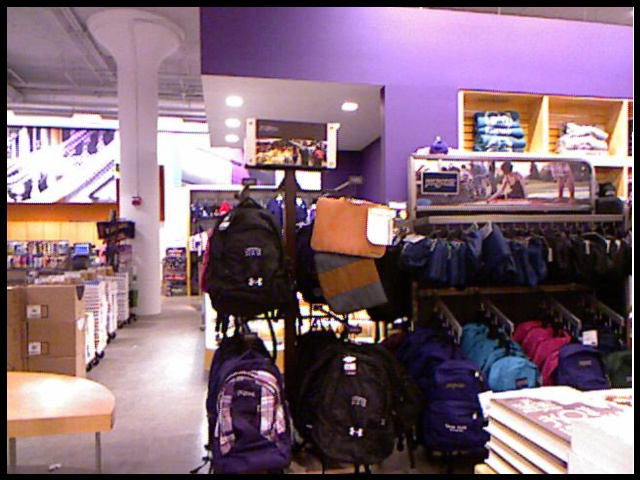

In [22]:
Image.open(test_files.items[0])

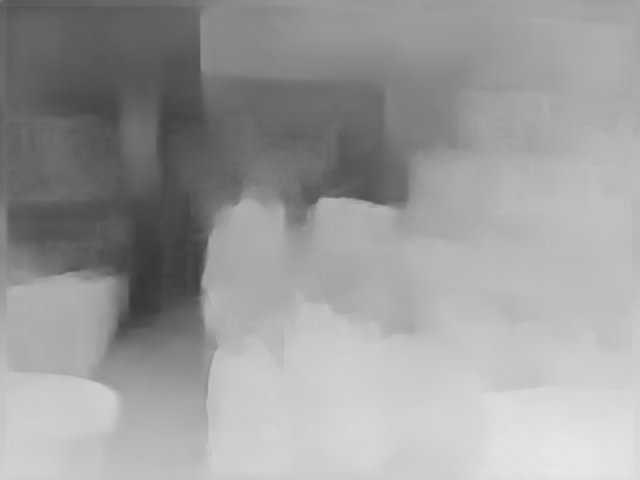

In [18]:
pred

#### Your model is now loaded and ready!

## Making sure our model learned something


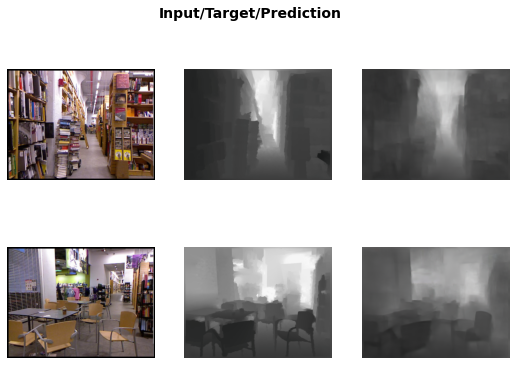

In [10]:
learner.show_results()

### Qualitative Results testing
We can upload an image and run the model on it

/content
/content/images


Saving grumpy.jpg to grumpy.jpg
/content


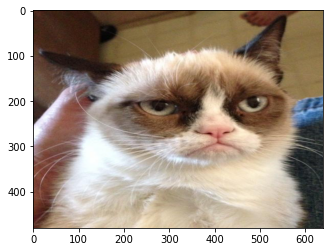

In [23]:
%cd /content/
%mkdir images
%cd images

from google.colab import files
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


# Upload Image
uploaded = files.upload()
original = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))

%cd /content/

original_shape = (original.shape[1],original.shape[0])
minified = original.resize((640,480))
minified_arr = np.array(minified)

plt.imshow(minified_arr)

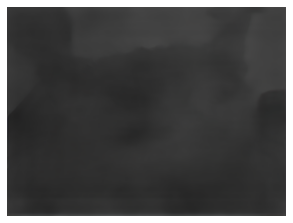

In [24]:
predicted_depth_map = (learner.predict(minified_arr))[0]
show_image(predicted_depth_map)

In [ ]:
# Save our result
output = transforms.ToPILImage()(predicted_depth_map[:,:,:].type(torch.FloatTensor)).convert('L')
output = output.resize(original_shape)
output.save("images/" + list(uploaded.keys())[0].split('.')[0] + "_depth.jpg")

---
# Modifying the project!
If you've made it here, everything is set up. You have the code and data in the file viewer to the left. You can edit the files located in SavtaDepth/src/code/ as you like. You can see the YAML defining the project pipeline in dvc.yaml. If you change dependencies or outputs (for example, add an additional code file for the training stage), make sure you edit the pipeline to reflect this.

### Once you are done with your changes run the cell below to run the pipeline end-to-end
* You can run this multiple times if you've made a change and want to test it
* If you want to run only a specific stage you can change the `dvc repro` command to any other command you like.

▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽

In [ ]:
!dvc repro

**---Or---**<br/>
Run a specific stage and commit its results to dvc

In [28]:
# Using %run magic lets you see the progress bar properly!
# If you're not sure what command to run, look in the dvc.yaml file
%run -i src/code/eval.py src/data/processed/test

Predicting on test images:   0%|          | 0/654 [00:00<?, ?it/s]

Predicting on test images:   0%|          | 1/654 [00:00<04:42,  2.31it/s]

Predicting on test images:   0%|          | 2/654 [00:00<04:22,  2.49it/s]

Predicting on test images:   0%|          | 3/654 [00:01<04:06,  2.64it/s]

Predicting on test images:   1%|          | 4/654 [00:01<03:52,  2.79it/s]

Predicting on test images:   1%|          | 5/654 [00:01<03:39,  2.96it/s]

Predicting on test images:   1%|          | 6/654 [00:01<03:30,  3.08it/s]

Predicting on test images:   1%|          | 7/654 [00:02<03:22,  3.19it/s]

Predicting on test images:   1%|          | 8/654 [00:02<03:20,  3.23it/s]

Predicting on test images:   1%|▏         | 9/654 [00:02<03:15,  3.31it/s]

Predicting on test images:   2%|▏         | 10/654 [00:03<03:15,  3.30it/s]

Predicting on test images:   2%|▏         | 11/654 [00:03<03:09,  3.40it/s]

Predicting on test images:   2%|▏         | 12/654 [00:03<03:06,  3.44it/s]

Predicting on test images:   2%|▏         | 13/654 [00:03<03:03,  3.49it/s]

Predicting on test images:   2%|▏         | 14/654 [00:04<03:01,  3.53it/s]

Predicting on test images:   2%|▏         | 15/654 [00:04<02:58,  3.58it/s]

Predicting on test images:   2%|▏         | 16/654 [00:04<02:58,  3.57it/s]

Predicting on test images:   3%|▎         | 17/654 [00:05<02:57,  3.60it/s]

Predicting on test images:   3%|▎         | 18/654 [00:05<02:56,  3.61it/s]

Predicting on test images:   3%|▎         | 19/654 [00:05<02:54,  3.64it/s]

Predicting on test images:   3%|▎         | 20/654 [00:05<02:53,  3.66it/s]

Predicting on test images:   3%|▎         | 21/654 [00:06<02:56,  3.58it/s]

Predicting on test images:   3%|▎         | 22/654 [00:06<02:55,  3.60it/s]

Predicting on test images:   4%|▎         | 23/654 [00:06<02:54,  3.63it/s]

Predicting on test images:   4%|▎         | 24/654 [00:07<02:55,  3.60it/s]

Predicting on test images:   4%|▍         | 25/654 [00:07<02:55,  3.58it/s]

Predicting on test images:   4%|▍         | 26/654 [00:07<02:55,  3.58it/s]

Predicting on test images:   4%|▍         | 27/654 [00:07<02:54,  3.58it/s]

Predicting on test images:   4%|▍         | 28/654 [00:08<02:53,  3.61it/s]

Predicting on test images:   4%|▍         | 29/654 [00:08<02:52,  3.62it/s]

Predicting on test images:   5%|▍         | 30/654 [00:08<02:52,  3.63it/s]

Predicting on test images:   5%|▍         | 31/654 [00:08<02:52,  3.60it/s]

Predicting on test images:   5%|▍         | 32/654 [00:09<02:54,  3.57it/s]

Predicting on test images:   5%|▌         | 33/654 [00:09<02:51,  3.62it/s]

Predicting on test images:   5%|▌         | 34/654 [00:09<02:49,  3.66it/s]

Predicting on test images:   5%|▌         | 35/654 [00:10<02:50,  3.64it/s]

Predicting on test images:   6%|▌         | 36/654 [00:10<02:50,  3.62it/s]

Predicting on test images:   6%|▌         | 37/654 [00:10<02:49,  3.63it/s]

Predicting on test images:   6%|▌         | 38/654 [00:10<02:48,  3.65it/s]

Predicting on test images:   6%|▌         | 39/654 [00:11<02:48,  3.66it/s]

Predicting on test images:   6%|▌         | 40/654 [00:11<02:47,  3.66it/s]

Predicting on test images:   6%|▋         | 41/654 [00:11<02:46,  3.69it/s]

Predicting on test images:   6%|▋         | 42/654 [00:11<02:46,  3.68it/s]

Predicting on test images:   7%|▋         | 43/654 [00:12<02:45,  3.70it/s]

Predicting on test images:   7%|▋         | 44/654 [00:12<02:44,  3.70it/s]

Predicting on test images:   7%|▋         | 45/654 [00:12<02:44,  3.70it/s]

Predicting on test images:   7%|▋         | 46/654 [00:13<02:45,  3.68it/s]

Predicting on test images:   7%|▋         | 47/654 [00:13<02:47,  3.61it/s]

Predicting on test images:   7%|▋         | 48/654 [00:13<02:46,  3.63it/s]

Predicting on test images:   7%|▋         | 49/654 [00:13<02:45,  3.65it/s]

Predicting on test images:   8%|▊         | 50/654 [00:14<02:45,  3.66it/s]

Predicting on test images:   8%|▊         | 51/654 [00:14<02:45,  3.65it/s]

Predicting on test images:   8%|▊         | 52/654 [00:14<02:45,  3.65it/s]

Predicting on test images:   8%|▊         | 53/654 [00:15<02:46,  3.61it/s]

Predicting on test images:   8%|▊         | 54/654 [00:15<02:45,  3.64it/s]

Predicting on test images:   8%|▊         | 55/654 [00:15<02:44,  3.64it/s]

Predicting on test images:   9%|▊         | 56/654 [00:15<02:44,  3.63it/s]

Predicting on test images:   9%|▊         | 57/654 [00:16<02:45,  3.61it/s]

Predicting on test images:   9%|▉         | 58/654 [00:16<02:47,  3.57it/s]

Predicting on test images:   9%|▉         | 59/654 [00:16<02:45,  3.59it/s]

Predicting on test images:   9%|▉         | 60/654 [00:16<02:45,  3.60it/s]

Predicting on test images:   9%|▉         | 61/654 [00:17<02:44,  3.60it/s]

Predicting on test images:   9%|▉         | 62/654 [00:17<02:44,  3.60it/s]

Predicting on test images:  10%|▉         | 63/654 [00:17<02:42,  3.63it/s]

Predicting on test images:  10%|▉         | 64/654 [00:18<02:41,  3.65it/s]

Predicting on test images:  10%|▉         | 65/654 [00:18<02:40,  3.67it/s]

Predicting on test images:  10%|█         | 66/654 [00:18<02:39,  3.68it/s]

Predicting on test images:  10%|█         | 67/654 [00:18<02:39,  3.69it/s]

Predicting on test images:  10%|█         | 68/654 [00:19<02:41,  3.64it/s]

Predicting on test images:  11%|█         | 69/654 [00:19<02:42,  3.60it/s]

Predicting on test images:  11%|█         | 70/654 [00:19<02:40,  3.63it/s]

Predicting on test images:  11%|█         | 71/654 [00:19<02:39,  3.66it/s]

Predicting on test images:  11%|█         | 72/654 [00:20<02:38,  3.66it/s]

Predicting on test images:  11%|█         | 73/654 [00:20<02:39,  3.64it/s]

Predicting on test images:  11%|█▏        | 74/654 [00:20<02:37,  3.67it/s]

Predicting on test images:  11%|█▏        | 75/654 [00:21<02:37,  3.68it/s]

Predicting on test images:  12%|█▏        | 76/654 [00:21<02:38,  3.66it/s]

Predicting on test images:  12%|█▏        | 77/654 [00:21<02:40,  3.60it/s]

Predicting on test images:  12%|█▏        | 78/654 [00:21<02:39,  3.61it/s]

Predicting on test images:  12%|█▏        | 79/654 [00:22<02:39,  3.60it/s]

Predicting on test images:  12%|█▏        | 80/654 [00:22<02:38,  3.62it/s]

Predicting on test images:  12%|█▏        | 81/654 [00:22<02:38,  3.62it/s]

Predicting on test images:  13%|█▎        | 82/654 [00:22<02:37,  3.63it/s]

Predicting on test images:  13%|█▎        | 83/654 [00:23<02:38,  3.59it/s]

Predicting on test images:  13%|█▎        | 84/654 [00:23<02:37,  3.62it/s]

Predicting on test images:  13%|█▎        | 85/654 [00:23<02:37,  3.60it/s]

Predicting on test images:  13%|█▎        | 86/654 [00:24<02:37,  3.60it/s]

Predicting on test images:  13%|█▎        | 87/654 [00:24<02:36,  3.63it/s]

Predicting on test images:  13%|█▎        | 88/654 [00:24<02:38,  3.57it/s]

Predicting on test images:  14%|█▎        | 89/654 [00:24<02:38,  3.56it/s]

Predicting on test images:  14%|█▍        | 90/654 [00:25<02:39,  3.54it/s]

Predicting on test images:  14%|█▍        | 91/654 [00:25<02:38,  3.55it/s]

Predicting on test images:  14%|█▍        | 92/654 [00:25<02:38,  3.55it/s]

Predicting on test images:  15%|█▍        | 95/654 [00:26<02:39,  3.50it/s]

Predicting on test images:  15%|█▍        | 96/654 [00:26<02:38,  3.53it/s]

Predicting on test images:  15%|█▍        | 97/654 [00:27<02:38,  3.52it/s]

Predicting on test images:  15%|█▍        | 98/654 [00:27<02:36,  3.55it/s]

Predicting on test images:  15%|█▌        | 99/654 [00:27<02:35,  3.56it/s]

Predicting on test images:  15%|█▌        | 100/654 [00:28<02:35,  3.56it/s]

Predicting on test images:  15%|█▌        | 101/654 [00:28<02:36,  3.53it/s]

Predicting on test images:  16%|█▌        | 102/654 [00:28<02:34,  3.57it/s]

Predicting on test images:  16%|█▌        | 103/654 [00:28<02:35,  3.55it/s]

Predicting on test images:  16%|█▌        | 104/654 [00:29<02:35,  3.55it/s]

Predicting on test images:  16%|█▌        | 105/654 [00:29<02:33,  3.57it/s]

Predicting on test images:  16%|█▌        | 106/654 [00:29<02:33,  3.56it/s]

Predicting on test images:  16%|█▋        | 107/654 [00:30<02:33,  3.56it/s]

Predicting on test images:  17%|█▋        | 108/654 [00:30<02:32,  3.57it/s]

Predicting on test images:  17%|█▋        | 109/654 [00:30<02:33,  3.55it/s]

Predicting on test images:  17%|█▋        | 110/654 [00:30<02:32,  3.57it/s]

Predicting on test images:  17%|█▋        | 111/654 [00:31<02:32,  3.55it/s]

Predicting on test images:  17%|█▋        | 112/654 [00:31<02:31,  3.57it/s]

Predicting on test images:  17%|█▋        | 113/654 [00:31<02:30,  3.59it/s]

Predicting on test images:  17%|█▋        | 114/654 [00:31<02:30,  3.60it/s]

Predicting on test images:  18%|█▊        | 115/654 [00:32<02:30,  3.58it/s]

Predicting on test images:  18%|█▊        | 116/654 [00:32<02:30,  3.58it/s]

Predicting on test images:  18%|█▊        | 117/654 [00:32<02:30,  3.57it/s]

Predicting on test images:  18%|█▊        | 118/654 [00:33<02:30,  3.56it/s]

Predicting on test images:  18%|█▊        | 119/654 [00:33<02:29,  3.59it/s]

Predicting on test images:  18%|█▊        | 120/654 [00:33<02:30,  3.55it/s]

Predicting on test images:  19%|█▊        | 121/654 [00:33<02:30,  3.53it/s]

Predicting on test images:  19%|█▊        | 122/654 [00:34<02:30,  3.53it/s]

Predicting on test images:  19%|█▉        | 123/654 [00:34<02:30,  3.54it/s]

Predicting on test images:  19%|█▉        | 124/654 [00:34<02:28,  3.56it/s]

Predicting on test images:  19%|█▉        | 125/654 [00:35<02:28,  3.56it/s]

Predicting on test images:  19%|█▉        | 126/654 [00:35<02:28,  3.55it/s]

Predicting on test images:  19%|█▉        | 127/654 [00:35<02:28,  3.55it/s]

Predicting on test images:  20%|█▉        | 128/654 [00:35<02:27,  3.56it/s]

Predicting on test images:  20%|█▉        | 129/654 [00:36<02:28,  3.54it/s]

Predicting on test images:  20%|█▉        | 130/654 [00:36<02:28,  3.53it/s]

Predicting on test images:  20%|██        | 131/654 [00:36<02:28,  3.51it/s]

Predicting on test images:  20%|██        | 132/654 [00:37<02:28,  3.51it/s]

Predicting on test images:  20%|██        | 133/654 [00:37<02:28,  3.50it/s]

Predicting on test images:  20%|██        | 134/654 [00:37<02:29,  3.48it/s]

Predicting on test images:  21%|██        | 135/654 [00:37<02:28,  3.50it/s]

Predicting on test images:  21%|██        | 136/654 [00:38<02:27,  3.50it/s]

Predicting on test images:  21%|██        | 137/654 [00:38<02:29,  3.47it/s]

Predicting on test images:  21%|██        | 138/654 [00:38<02:28,  3.48it/s]

Predicting on test images:  21%|██▏       | 139/654 [00:39<02:27,  3.48it/s]

Predicting on test images:  21%|██▏       | 140/654 [00:39<02:27,  3.48it/s]

Predicting on test images:  22%|██▏       | 141/654 [00:39<02:26,  3.50it/s]

Predicting on test images:  22%|██▏       | 142/654 [00:39<02:26,  3.50it/s]

Predicting on test images:  22%|██▏       | 143/654 [00:40<02:26,  3.49it/s]

Predicting on test images:  22%|██▏       | 144/654 [00:40<02:27,  3.46it/s]

Predicting on test images:  22%|██▏       | 145/654 [00:40<02:26,  3.47it/s]

Predicting on test images:  22%|██▏       | 146/654 [00:41<02:25,  3.48it/s]

Predicting on test images:  22%|██▏       | 147/654 [00:41<02:25,  3.49it/s]

Predicting on test images:  23%|██▎       | 148/654 [00:41<02:25,  3.49it/s]

Predicting on test images:  23%|██▎       | 149/654 [00:41<02:23,  3.52it/s]

Predicting on test images:  23%|██▎       | 150/654 [00:42<02:23,  3.51it/s]

Predicting on test images:  23%|██▎       | 151/654 [00:42<02:23,  3.52it/s]

Predicting on test images:  23%|██▎       | 152/654 [00:42<02:23,  3.49it/s]

Predicting on test images:  23%|██▎       | 153/654 [00:43<02:23,  3.50it/s]

Predicting on test images:  24%|██▎       | 154/654 [00:43<02:23,  3.50it/s]

Predicting on test images:  24%|██▎       | 155/654 [00:43<02:22,  3.50it/s]

Predicting on test images:  24%|██▍       | 156/654 [00:43<02:20,  3.54it/s]

Predicting on test images:  24%|██▍       | 157/654 [00:44<02:21,  3.51it/s]

Predicting on test images:  24%|██▍       | 158/654 [00:44<02:21,  3.49it/s]

Predicting on test images:  24%|██▍       | 159/654 [00:44<02:21,  3.49it/s]

Predicting on test images:  24%|██▍       | 160/654 [00:45<02:21,  3.50it/s]

Predicting on test images:  25%|██▍       | 161/654 [00:45<02:21,  3.49it/s]

Predicting on test images:  25%|██▍       | 162/654 [00:45<02:20,  3.49it/s]

Predicting on test images:  25%|██▍       | 163/654 [00:45<02:20,  3.50it/s]

Predicting on test images:  25%|██▌       | 164/654 [00:46<02:19,  3.52it/s]

Predicting on test images:  25%|██▌       | 165/654 [00:46<02:18,  3.53it/s]

Predicting on test images:  25%|██▌       | 166/654 [00:46<02:19,  3.49it/s]

Predicting on test images:  26%|██▌       | 167/654 [00:47<02:18,  3.52it/s]

Predicting on test images:  26%|██▌       | 168/654 [00:47<02:19,  3.49it/s]

Predicting on test images:  26%|██▌       | 169/654 [00:47<02:20,  3.46it/s]

Predicting on test images:  26%|██▌       | 170/654 [00:47<02:19,  3.47it/s]

Predicting on test images:  26%|██▌       | 171/654 [00:48<02:19,  3.46it/s]

Predicting on test images:  26%|██▋       | 172/654 [00:48<02:19,  3.46it/s]

Predicting on test images:  26%|██▋       | 173/654 [00:48<02:18,  3.46it/s]

Predicting on test images:  27%|██▋       | 174/654 [00:49<02:17,  3.49it/s]

Predicting on test images:  27%|██▋       | 175/654 [00:49<02:16,  3.50it/s]

Predicting on test images:  27%|██▋       | 176/654 [00:49<02:18,  3.46it/s]

Predicting on test images:  27%|██▋       | 177/654 [00:49<02:17,  3.48it/s]

Predicting on test images:  27%|██▋       | 178/654 [00:50<02:16,  3.50it/s]

Predicting on test images:  27%|██▋       | 179/654 [00:50<02:15,  3.50it/s]

Predicting on test images:  28%|██▊       | 180/654 [00:50<02:16,  3.48it/s]

Predicting on test images:  28%|██▊       | 181/654 [00:51<02:15,  3.49it/s]

Predicting on test images:  28%|██▊       | 182/654 [00:51<02:15,  3.49it/s]

Predicting on test images:  28%|██▊       | 183/654 [00:51<02:15,  3.48it/s]

Predicting on test images:  28%|██▊       | 184/654 [00:51<02:14,  3.50it/s]

Predicting on test images:  28%|██▊       | 185/654 [00:52<02:14,  3.49it/s]

Predicting on test images:  28%|██▊       | 186/654 [00:52<02:14,  3.48it/s]

Predicting on test images:  29%|██▊       | 187/654 [00:52<02:14,  3.47it/s]

Predicting on test images:  29%|██▊       | 188/654 [00:53<02:13,  3.49it/s]

Predicting on test images:  29%|██▉       | 189/654 [00:53<02:13,  3.47it/s]

Predicting on test images:  29%|██▉       | 190/654 [00:53<02:13,  3.46it/s]

Predicting on test images:  29%|██▉       | 191/654 [00:54<02:16,  3.40it/s]

Predicting on test images:  29%|██▉       | 192/654 [00:54<02:15,  3.42it/s]

Predicting on test images:  30%|██▉       | 193/654 [00:54<02:16,  3.39it/s]

Predicting on test images:  30%|██▉       | 194/654 [00:54<02:14,  3.42it/s]

Predicting on test images:  30%|██▉       | 195/654 [00:55<02:12,  3.45it/s]

Predicting on test images:  30%|██▉       | 196/654 [00:55<02:12,  3.45it/s]

Predicting on test images:  30%|███       | 197/654 [00:55<02:14,  3.40it/s]

Predicting on test images:  30%|███       | 198/654 [00:56<02:13,  3.43it/s]

Predicting on test images:  30%|███       | 199/654 [00:56<02:12,  3.43it/s]

Predicting on test images:  31%|███       | 200/654 [00:56<02:10,  3.48it/s]

Predicting on test images:  31%|███       | 201/654 [00:56<02:09,  3.51it/s]

Predicting on test images:  31%|███       | 202/654 [00:57<02:08,  3.51it/s]

Predicting on test images:  31%|███       | 203/654 [00:57<02:08,  3.51it/s]

Predicting on test images:  31%|███       | 204/654 [00:57<02:08,  3.51it/s]

Predicting on test images:  31%|███▏      | 205/654 [00:58<02:08,  3.49it/s]

Predicting on test images:  31%|███▏      | 206/654 [00:58<02:08,  3.48it/s]

Predicting on test images:  32%|███▏      | 207/654 [00:58<02:07,  3.52it/s]

Predicting on test images:  32%|███▏      | 208/654 [00:58<02:06,  3.52it/s]

Predicting on test images:  32%|███▏      | 209/654 [00:59<02:05,  3.54it/s]

Predicting on test images:  32%|███▏      | 210/654 [00:59<02:05,  3.55it/s]

Predicting on test images:  32%|███▏      | 211/654 [00:59<02:04,  3.55it/s]

Predicting on test images:  32%|███▏      | 212/654 [01:00<02:05,  3.53it/s]

Predicting on test images:  33%|███▎      | 213/654 [01:00<02:04,  3.55it/s]

Predicting on test images:  33%|███▎      | 214/654 [01:00<02:05,  3.51it/s]

Predicting on test images:  33%|███▎      | 215/654 [01:00<02:06,  3.48it/s]

Predicting on test images:  33%|███▎      | 216/654 [01:01<02:06,  3.45it/s]

Predicting on test images:  33%|███▎      | 217/654 [01:01<02:05,  3.49it/s]

Predicting on test images:  33%|███▎      | 218/654 [01:01<02:04,  3.51it/s]

Predicting on test images:  33%|███▎      | 219/654 [01:02<02:02,  3.54it/s]

Predicting on test images:  34%|███▎      | 220/654 [01:02<02:03,  3.50it/s]

Predicting on test images:  34%|███▍      | 221/654 [01:02<02:03,  3.50it/s]

Predicting on test images:  34%|███▍      | 222/654 [01:02<02:02,  3.52it/s]

Predicting on test images:  34%|███▍      | 223/654 [01:03<02:03,  3.50it/s]

Predicting on test images:  34%|███▍      | 224/654 [01:03<02:02,  3.51it/s]

Predicting on test images:  34%|███▍      | 225/654 [01:03<02:02,  3.50it/s]

Predicting on test images:  35%|███▍      | 226/654 [01:04<02:01,  3.51it/s]

Predicting on test images:  35%|███▍      | 227/654 [01:04<02:02,  3.50it/s]

Predicting on test images:  35%|███▍      | 228/654 [01:04<02:01,  3.49it/s]

Predicting on test images:  35%|███▌      | 229/654 [01:04<02:01,  3.49it/s]

Predicting on test images:  35%|███▌      | 230/654 [01:05<02:01,  3.48it/s]

Predicting on test images:  35%|███▌      | 231/654 [01:05<02:01,  3.48it/s]

Predicting on test images:  35%|███▌      | 232/654 [01:05<02:01,  3.48it/s]

Predicting on test images:  36%|███▌      | 233/654 [01:06<02:01,  3.48it/s]

Predicting on test images:  36%|███▌      | 234/654 [01:06<02:00,  3.49it/s]

Predicting on test images:  36%|███▌      | 235/654 [01:06<02:00,  3.49it/s]

Predicting on test images:  36%|███▌      | 236/654 [01:06<02:00,  3.48it/s]

Predicting on test images:  36%|███▌      | 237/654 [01:07<02:01,  3.43it/s]

Predicting on test images:  36%|███▋      | 238/654 [01:07<02:00,  3.46it/s]

Predicting on test images:  37%|███▋      | 239/654 [01:07<02:00,  3.45it/s]

Predicting on test images:  37%|███▋      | 240/654 [01:08<02:00,  3.45it/s]

Predicting on test images:  37%|███▋      | 241/654 [01:08<01:59,  3.47it/s]

Predicting on test images:  37%|███▋      | 242/654 [01:08<01:57,  3.51it/s]

Predicting on test images:  37%|███▋      | 243/654 [01:08<01:57,  3.51it/s]

Predicting on test images:  37%|███▋      | 244/654 [01:09<01:56,  3.53it/s]

Predicting on test images:  37%|███▋      | 245/654 [01:09<01:56,  3.50it/s]

Predicting on test images:  38%|███▊      | 246/654 [01:09<01:55,  3.52it/s]

Predicting on test images:  38%|███▊      | 247/654 [01:10<01:55,  3.52it/s]

Predicting on test images:  38%|███▊      | 248/654 [01:10<01:55,  3.52it/s]

Predicting on test images:  38%|███▊      | 249/654 [01:10<01:54,  3.53it/s]

Predicting on test images:  38%|███▊      | 250/654 [01:10<01:55,  3.50it/s]

Predicting on test images:  38%|███▊      | 251/654 [01:11<01:54,  3.51it/s]

Predicting on test images:  39%|███▊      | 252/654 [01:11<01:54,  3.52it/s]

Predicting on test images:  39%|███▊      | 253/654 [01:11<01:55,  3.49it/s]

Predicting on test images:  39%|███▉      | 254/654 [01:12<01:55,  3.45it/s]

Predicting on test images:  39%|███▉      | 255/654 [01:12<01:55,  3.45it/s]

Predicting on test images:  39%|███▉      | 256/654 [01:12<01:56,  3.42it/s]

Predicting on test images:  39%|███▉      | 257/654 [01:12<01:54,  3.46it/s]

Predicting on test images:  39%|███▉      | 258/654 [01:13<01:53,  3.47it/s]

Predicting on test images:  40%|███▉      | 259/654 [01:13<01:53,  3.48it/s]

Predicting on test images:  40%|███▉      | 260/654 [01:13<01:52,  3.51it/s]

Predicting on test images:  40%|███▉      | 261/654 [01:14<01:52,  3.50it/s]

Predicting on test images:  40%|████      | 262/654 [01:14<01:52,  3.48it/s]

Predicting on test images:  40%|████      | 263/654 [01:14<01:53,  3.45it/s]

Predicting on test images:  40%|████      | 264/654 [01:14<01:51,  3.49it/s]

Predicting on test images:  41%|████      | 265/654 [01:15<01:52,  3.47it/s]

Predicting on test images:  41%|████      | 266/654 [01:15<01:51,  3.48it/s]

Predicting on test images:  41%|████      | 267/654 [01:15<01:52,  3.45it/s]

Predicting on test images:  41%|████      | 268/654 [01:16<01:51,  3.45it/s]

Predicting on test images:  41%|████      | 269/654 [01:16<01:52,  3.41it/s]

Predicting on test images:  41%|████▏     | 270/654 [01:16<01:51,  3.46it/s]

Predicting on test images:  41%|████▏     | 271/654 [01:16<01:52,  3.40it/s]

Predicting on test images:  42%|████▏     | 272/654 [01:17<01:51,  3.44it/s]

Predicting on test images:  42%|████▏     | 273/654 [01:17<01:50,  3.44it/s]

Predicting on test images:  42%|████▏     | 274/654 [01:17<01:51,  3.42it/s]

Predicting on test images:  42%|████▏     | 275/654 [01:18<01:51,  3.40it/s]

Predicting on test images:  42%|████▏     | 276/654 [01:18<01:50,  3.42it/s]

Predicting on test images:  42%|████▏     | 277/654 [01:18<01:50,  3.40it/s]

Predicting on test images:  43%|████▎     | 278/654 [01:19<01:50,  3.41it/s]

Predicting on test images:  43%|████▎     | 279/654 [01:19<01:49,  3.43it/s]

Predicting on test images:  43%|████▎     | 280/654 [01:19<01:49,  3.43it/s]

Predicting on test images:  43%|████▎     | 281/654 [01:19<01:49,  3.41it/s]

Predicting on test images:  43%|████▎     | 282/654 [01:20<01:50,  3.36it/s]

Predicting on test images:  43%|████▎     | 283/654 [01:20<01:50,  3.36it/s]

Predicting on test images:  43%|████▎     | 284/654 [01:20<01:49,  3.39it/s]

Predicting on test images:  44%|████▎     | 285/654 [01:21<01:49,  3.36it/s]

Predicting on test images:  44%|████▎     | 286/654 [01:21<01:48,  3.38it/s]

Predicting on test images:  44%|████▍     | 287/654 [01:21<01:47,  3.42it/s]

Predicting on test images:  44%|████▍     | 288/654 [01:21<01:47,  3.41it/s]

Predicting on test images:  44%|████▍     | 289/654 [01:22<01:47,  3.41it/s]

Predicting on test images:  44%|████▍     | 290/654 [01:22<01:45,  3.44it/s]

Predicting on test images:  44%|████▍     | 291/654 [01:22<01:45,  3.45it/s]

Predicting on test images:  45%|████▍     | 292/654 [01:23<01:45,  3.44it/s]

Predicting on test images:  45%|████▍     | 293/654 [01:23<01:45,  3.43it/s]

Predicting on test images:  45%|████▍     | 294/654 [01:23<01:44,  3.44it/s]

Predicting on test images:  45%|████▌     | 295/654 [01:23<01:44,  3.43it/s]

Predicting on test images:  45%|████▌     | 296/654 [01:24<01:43,  3.46it/s]

Predicting on test images:  45%|████▌     | 297/654 [01:24<01:43,  3.47it/s]

Predicting on test images:  46%|████▌     | 298/654 [01:24<01:43,  3.44it/s]

Predicting on test images:  46%|████▌     | 299/654 [01:25<01:43,  3.44it/s]

Predicting on test images:  46%|████▌     | 300/654 [01:25<01:42,  3.44it/s]

Predicting on test images:  46%|████▌     | 301/654 [01:25<01:42,  3.43it/s]

Predicting on test images:  46%|████▌     | 302/654 [01:26<01:43,  3.40it/s]

Predicting on test images:  46%|████▋     | 303/654 [01:26<01:43,  3.40it/s]

Predicting on test images:  46%|████▋     | 304/654 [01:26<01:42,  3.43it/s]

Predicting on test images:  47%|████▋     | 305/654 [01:26<01:42,  3.42it/s]

Predicting on test images:  47%|████▋     | 306/654 [01:27<01:42,  3.41it/s]

Predicting on test images:  47%|████▋     | 307/654 [01:27<01:41,  3.42it/s]

Predicting on test images:  47%|████▋     | 308/654 [01:27<01:40,  3.45it/s]

Predicting on test images:  47%|████▋     | 309/654 [01:28<01:40,  3.42it/s]

Predicting on test images:  47%|████▋     | 310/654 [01:28<01:40,  3.43it/s]

Predicting on test images:  48%|████▊     | 311/654 [01:28<01:41,  3.36it/s]

Predicting on test images:  48%|████▊     | 312/654 [01:28<01:41,  3.36it/s]

Predicting on test images:  48%|████▊     | 313/654 [01:29<01:41,  3.35it/s]

Predicting on test images:  48%|████▊     | 314/654 [01:29<01:40,  3.39it/s]

Predicting on test images:  48%|████▊     | 315/654 [01:29<01:40,  3.37it/s]

Predicting on test images:  48%|████▊     | 316/654 [01:30<01:39,  3.38it/s]

Predicting on test images:  48%|████▊     | 317/654 [01:30<01:39,  3.39it/s]

Predicting on test images:  49%|████▊     | 318/654 [01:30<01:39,  3.39it/s]

Predicting on test images:  49%|████▉     | 319/654 [01:31<01:39,  3.38it/s]

Predicting on test images:  49%|████▉     | 320/654 [01:31<01:39,  3.37it/s]

Predicting on test images:  49%|████▉     | 321/654 [01:31<01:37,  3.41it/s]

Predicting on test images:  49%|████▉     | 322/654 [01:31<01:36,  3.42it/s]

Predicting on test images:  49%|████▉     | 323/654 [01:32<01:36,  3.42it/s]

Predicting on test images:  50%|████▉     | 324/654 [01:32<01:36,  3.41it/s]

Predicting on test images:  50%|████▉     | 325/654 [01:32<01:36,  3.41it/s]

Predicting on test images:  50%|████▉     | 326/654 [01:33<01:36,  3.40it/s]

Predicting on test images:  50%|█████     | 327/654 [01:33<01:36,  3.39it/s]

Predicting on test images:  50%|█████     | 328/654 [01:33<01:36,  3.39it/s]

Predicting on test images:  50%|█████     | 329/654 [01:33<01:36,  3.38it/s]

Predicting on test images:  50%|█████     | 330/654 [01:34<01:35,  3.39it/s]

Predicting on test images:  51%|█████     | 331/654 [01:34<01:35,  3.37it/s]

Predicting on test images:  51%|█████     | 332/654 [01:34<01:35,  3.37it/s]

Predicting on test images:  51%|█████     | 333/654 [01:35<01:34,  3.39it/s]

Predicting on test images:  51%|█████     | 334/654 [01:35<01:34,  3.39it/s]

Predicting on test images:  51%|█████     | 335/654 [01:35<01:33,  3.40it/s]

Predicting on test images:  51%|█████▏    | 336/654 [01:36<01:32,  3.42it/s]

Predicting on test images:  52%|█████▏    | 337/654 [01:36<01:33,  3.40it/s]

Predicting on test images:  52%|█████▏    | 338/654 [01:36<01:33,  3.39it/s]

Predicting on test images:  52%|█████▏    | 339/654 [01:36<01:32,  3.42it/s]

Predicting on test images:  52%|█████▏    | 340/654 [01:37<01:32,  3.39it/s]

Predicting on test images:  52%|█████▏    | 341/654 [01:37<01:31,  3.42it/s]

Predicting on test images:  52%|█████▏    | 342/654 [01:37<01:31,  3.40it/s]

Predicting on test images:  52%|█████▏    | 343/654 [01:38<01:32,  3.37it/s]

Predicting on test images:  53%|█████▎    | 344/654 [01:38<01:31,  3.40it/s]

Predicting on test images:  53%|█████▎    | 345/654 [01:38<01:30,  3.42it/s]

Predicting on test images:  53%|█████▎    | 346/654 [01:38<01:30,  3.41it/s]

Predicting on test images:  53%|█████▎    | 347/654 [01:39<01:29,  3.42it/s]

Predicting on test images:  53%|█████▎    | 348/654 [01:39<01:29,  3.42it/s]

Predicting on test images:  53%|█████▎    | 349/654 [01:39<01:29,  3.40it/s]

Predicting on test images:  54%|█████▎    | 350/654 [01:40<01:29,  3.38it/s]

Predicting on test images:  54%|█████▎    | 351/654 [01:40<01:29,  3.40it/s]

Predicting on test images:  54%|█████▍    | 352/654 [01:40<01:28,  3.40it/s]

Predicting on test images:  54%|█████▍    | 353/654 [01:41<01:29,  3.37it/s]

Predicting on test images:  54%|█████▍    | 354/654 [01:41<01:29,  3.36it/s]

Predicting on test images:  54%|█████▍    | 355/654 [01:41<01:30,  3.30it/s]

Predicting on test images:  54%|█████▍    | 356/654 [01:41<01:29,  3.33it/s]

Predicting on test images:  55%|█████▍    | 357/654 [01:42<01:28,  3.35it/s]

Predicting on test images:  55%|█████▍    | 358/654 [01:42<01:27,  3.37it/s]

Predicting on test images:  55%|█████▍    | 359/654 [01:42<01:26,  3.39it/s]

Predicting on test images:  55%|█████▌    | 360/654 [01:43<01:26,  3.39it/s]

Predicting on test images:  55%|█████▌    | 361/654 [01:43<01:27,  3.34it/s]

Predicting on test images:  55%|█████▌    | 362/654 [01:43<01:27,  3.32it/s]

Predicting on test images:  56%|█████▌    | 363/654 [01:44<01:27,  3.34it/s]

Predicting on test images:  56%|█████▌    | 364/654 [01:44<01:25,  3.38it/s]

Predicting on test images:  56%|█████▌    | 365/654 [01:44<01:25,  3.39it/s]

Predicting on test images:  56%|█████▌    | 366/654 [01:44<01:24,  3.41it/s]

Predicting on test images:  56%|█████▌    | 367/654 [01:45<01:24,  3.39it/s]

Predicting on test images:  56%|█████▋    | 368/654 [01:45<01:24,  3.39it/s]

Predicting on test images:  56%|█████▋    | 369/654 [01:45<01:23,  3.40it/s]

Predicting on test images:  57%|█████▋    | 370/654 [01:46<01:23,  3.40it/s]

Predicting on test images:  57%|█████▋    | 371/654 [01:46<01:24,  3.37it/s]

Predicting on test images:  57%|█████▋    | 372/654 [01:46<01:22,  3.40it/s]

Predicting on test images:  57%|█████▋    | 373/654 [01:46<01:22,  3.42it/s]

Predicting on test images:  57%|█████▋    | 374/654 [01:47<01:21,  3.42it/s]

Predicting on test images:  57%|█████▋    | 375/654 [01:47<01:22,  3.37it/s]

Predicting on test images:  57%|█████▋    | 376/654 [01:47<01:22,  3.37it/s]

Predicting on test images:  58%|█████▊    | 377/654 [01:48<01:21,  3.41it/s]

Predicting on test images:  58%|█████▊    | 378/654 [01:48<01:21,  3.38it/s]

Predicting on test images:  58%|█████▊    | 379/654 [01:48<01:21,  3.37it/s]

Predicting on test images:  58%|█████▊    | 380/654 [01:49<01:21,  3.38it/s]

Predicting on test images:  58%|█████▊    | 381/654 [01:49<01:20,  3.40it/s]

Predicting on test images:  58%|█████▊    | 382/654 [01:49<01:20,  3.38it/s]

Predicting on test images:  59%|█████▊    | 383/654 [01:49<01:20,  3.37it/s]

Predicting on test images:  59%|█████▊    | 384/654 [01:50<01:20,  3.35it/s]

Predicting on test images:  59%|█████▉    | 385/654 [01:50<01:20,  3.36it/s]

Predicting on test images:  59%|█████▉    | 386/654 [01:50<01:20,  3.32it/s]

Predicting on test images:  59%|█████▉    | 387/654 [01:51<01:19,  3.34it/s]

Predicting on test images:  59%|█████▉    | 388/654 [01:51<01:18,  3.37it/s]

Predicting on test images:  59%|█████▉    | 389/654 [01:51<01:17,  3.40it/s]

Predicting on test images:  60%|█████▉    | 390/654 [01:52<01:17,  3.39it/s]

Predicting on test images:  60%|█████▉    | 391/654 [01:52<01:17,  3.37it/s]

Predicting on test images:  60%|█████▉    | 392/654 [01:52<01:17,  3.37it/s]

Predicting on test images:  60%|██████    | 393/654 [01:52<01:18,  3.34it/s]

Predicting on test images:  60%|██████    | 394/654 [01:53<01:17,  3.35it/s]

Predicting on test images:  60%|██████    | 395/654 [01:53<01:16,  3.36it/s]

Predicting on test images:  61%|██████    | 396/654 [01:53<01:16,  3.39it/s]

Predicting on test images:  61%|██████    | 397/654 [01:54<01:17,  3.33it/s]

Predicting on test images:  61%|██████    | 398/654 [01:54<01:16,  3.35it/s]

Predicting on test images:  61%|██████    | 399/654 [01:54<01:16,  3.33it/s]

Predicting on test images:  61%|██████    | 400/654 [01:55<01:16,  3.31it/s]

Predicting on test images:  61%|██████▏   | 401/654 [01:55<01:15,  3.34it/s]

Predicting on test images:  61%|██████▏   | 402/654 [01:55<01:15,  3.34it/s]

Predicting on test images:  62%|██████▏   | 403/654 [01:55<01:16,  3.30it/s]

Predicting on test images:  62%|██████▏   | 404/654 [01:56<01:15,  3.30it/s]

Predicting on test images:  62%|██████▏   | 405/654 [01:56<01:14,  3.33it/s]

Predicting on test images:  62%|██████▏   | 406/654 [01:56<01:14,  3.33it/s]

Predicting on test images:  62%|██████▏   | 407/654 [01:57<01:14,  3.30it/s]

Predicting on test images:  62%|██████▏   | 408/654 [01:57<01:14,  3.31it/s]

Predicting on test images:  63%|██████▎   | 409/654 [01:57<01:14,  3.29it/s]

Predicting on test images:  63%|██████▎   | 410/654 [01:58<01:13,  3.30it/s]

Predicting on test images:  63%|██████▎   | 411/654 [01:58<01:14,  3.27it/s]

Predicting on test images:  63%|██████▎   | 412/654 [01:58<01:13,  3.28it/s]

Predicting on test images:  63%|██████▎   | 413/654 [01:58<01:14,  3.25it/s]

Predicting on test images:  63%|██████▎   | 414/654 [01:59<01:13,  3.28it/s]

Predicting on test images:  63%|██████▎   | 415/654 [01:59<01:12,  3.31it/s]

Predicting on test images:  64%|██████▎   | 416/654 [01:59<01:11,  3.32it/s]

Predicting on test images:  64%|██████▍   | 417/654 [02:00<01:11,  3.33it/s]

Predicting on test images:  64%|██████▍   | 418/654 [02:00<01:10,  3.34it/s]

Predicting on test images:  64%|██████▍   | 419/654 [02:00<01:11,  3.30it/s]

Predicting on test images:  64%|██████▍   | 420/654 [02:01<01:10,  3.32it/s]

Predicting on test images:  64%|██████▍   | 421/654 [02:01<01:10,  3.32it/s]

Predicting on test images:  65%|██████▍   | 422/654 [02:01<01:10,  3.29it/s]

Predicting on test images:  65%|██████▍   | 423/654 [02:01<01:09,  3.30it/s]

Predicting on test images:  65%|██████▍   | 424/654 [02:02<01:09,  3.32it/s]

Predicting on test images:  65%|██████▍   | 425/654 [02:02<01:08,  3.32it/s]

Predicting on test images:  65%|██████▌   | 426/654 [02:02<01:07,  3.36it/s]

Predicting on test images:  65%|██████▌   | 427/654 [02:03<01:07,  3.38it/s]

Predicting on test images:  65%|██████▌   | 428/654 [02:03<01:06,  3.40it/s]

Predicting on test images:  66%|██████▌   | 429/654 [02:03<01:07,  3.36it/s]

Predicting on test images:  66%|██████▌   | 430/654 [02:04<01:07,  3.33it/s]

Predicting on test images:  66%|██████▌   | 431/654 [02:04<01:07,  3.31it/s]

Predicting on test images:  66%|██████▌   | 432/654 [02:04<01:07,  3.31it/s]

Predicting on test images:  66%|██████▌   | 433/654 [02:04<01:07,  3.28it/s]

Predicting on test images:  66%|██████▋   | 434/654 [02:05<01:06,  3.31it/s]

Predicting on test images:  67%|██████▋   | 435/654 [02:05<01:06,  3.31it/s]

Predicting on test images:  67%|██████▋   | 436/654 [02:05<01:06,  3.26it/s]

Predicting on test images:  67%|██████▋   | 437/654 [02:06<01:06,  3.27it/s]

Predicting on test images:  67%|██████▋   | 438/654 [02:06<01:05,  3.29it/s]

Predicting on test images:  67%|██████▋   | 439/654 [02:06<01:04,  3.31it/s]

Predicting on test images:  67%|██████▋   | 440/654 [02:07<01:04,  3.32it/s]

Predicting on test images:  67%|██████▋   | 441/654 [02:07<01:04,  3.30it/s]

Predicting on test images:  68%|██████▊   | 442/654 [02:07<01:04,  3.31it/s]

Predicting on test images:  68%|██████▊   | 443/654 [02:07<01:03,  3.33it/s]

Predicting on test images:  68%|██████▊   | 444/654 [02:08<01:02,  3.34it/s]

Predicting on test images:  68%|██████▊   | 445/654 [02:08<01:02,  3.37it/s]

Predicting on test images:  68%|██████▊   | 446/654 [02:08<01:01,  3.38it/s]

Predicting on test images:  68%|██████▊   | 447/654 [02:09<01:01,  3.35it/s]

Predicting on test images:  69%|██████▊   | 448/654 [02:09<01:01,  3.34it/s]

Predicting on test images:  69%|██████▊   | 449/654 [02:09<01:02,  3.29it/s]

Predicting on test images:  69%|██████▉   | 450/654 [02:10<01:02,  3.28it/s]

Predicting on test images:  69%|██████▉   | 451/654 [02:10<01:01,  3.30it/s]

Predicting on test images:  69%|██████▉   | 452/654 [02:10<01:01,  3.30it/s]

Predicting on test images:  69%|██████▉   | 453/654 [02:11<01:01,  3.27it/s]

Predicting on test images:  69%|██████▉   | 454/654 [02:11<01:00,  3.28it/s]

Predicting on test images:  70%|██████▉   | 455/654 [02:11<00:59,  3.33it/s]

Predicting on test images:  70%|██████▉   | 456/654 [02:11<00:59,  3.31it/s]

Predicting on test images:  70%|██████▉   | 457/654 [02:12<01:00,  3.27it/s]

Predicting on test images:  70%|███████   | 458/654 [02:12<00:59,  3.27it/s]

Predicting on test images:  70%|███████   | 459/654 [02:12<00:59,  3.28it/s]

Predicting on test images:  70%|███████   | 460/654 [02:13<00:59,  3.28it/s]

Predicting on test images:  70%|███████   | 461/654 [02:13<00:58,  3.32it/s]

Predicting on test images:  71%|███████   | 462/654 [02:13<00:57,  3.34it/s]

Predicting on test images:  71%|███████   | 463/654 [02:14<00:57,  3.30it/s]

Predicting on test images:  71%|███████   | 464/654 [02:14<00:57,  3.30it/s]

Predicting on test images:  71%|███████   | 465/654 [02:14<00:57,  3.30it/s]

Predicting on test images:  71%|███████▏  | 466/654 [02:14<00:56,  3.34it/s]

Predicting on test images:  71%|███████▏  | 467/654 [02:15<00:56,  3.33it/s]

Predicting on test images:  72%|███████▏  | 468/654 [02:15<00:56,  3.31it/s]

Predicting on test images:  72%|███████▏  | 469/654 [02:15<00:55,  3.33it/s]

Predicting on test images:  72%|███████▏  | 470/654 [02:16<00:55,  3.30it/s]

Predicting on test images:  72%|███████▏  | 471/654 [02:16<00:55,  3.29it/s]

Predicting on test images:  72%|███████▏  | 472/654 [02:16<00:55,  3.28it/s]

Predicting on test images:  72%|███████▏  | 473/654 [02:17<00:55,  3.28it/s]

Predicting on test images:  72%|███████▏  | 474/654 [02:17<00:54,  3.31it/s]

Predicting on test images:  73%|███████▎  | 475/654 [02:17<00:54,  3.31it/s]

Predicting on test images:  73%|███████▎  | 476/654 [02:17<00:53,  3.32it/s]

Predicting on test images:  73%|███████▎  | 477/654 [02:18<00:53,  3.33it/s]

Predicting on test images:  73%|███████▎  | 478/654 [02:18<00:52,  3.35it/s]

Predicting on test images:  73%|███████▎  | 479/654 [02:18<00:52,  3.33it/s]

Predicting on test images:  73%|███████▎  | 480/654 [02:19<00:52,  3.30it/s]

Predicting on test images:  74%|███████▎  | 481/654 [02:19<00:52,  3.30it/s]

Predicting on test images:  74%|███████▎  | 482/654 [02:19<00:52,  3.28it/s]

Predicting on test images:  74%|███████▍  | 483/654 [02:20<00:52,  3.28it/s]

Predicting on test images:  74%|███████▍  | 484/654 [02:20<00:51,  3.27it/s]

Predicting on test images:  74%|███████▍  | 485/654 [02:20<00:51,  3.28it/s]

Predicting on test images:  74%|███████▍  | 486/654 [02:21<00:51,  3.27it/s]

Predicting on test images:  74%|███████▍  | 487/654 [02:21<00:51,  3.27it/s]

Predicting on test images:  75%|███████▍  | 488/654 [02:21<00:50,  3.30it/s]

Predicting on test images:  75%|███████▍  | 489/654 [02:21<00:49,  3.31it/s]

Predicting on test images:  75%|███████▍  | 490/654 [02:22<00:49,  3.33it/s]

Predicting on test images:  75%|███████▌  | 491/654 [02:22<00:49,  3.28it/s]

Predicting on test images:  75%|███████▌  | 492/654 [02:22<00:49,  3.27it/s]

Predicting on test images:  75%|███████▌  | 493/654 [02:23<00:49,  3.25it/s]

Predicting on test images:  76%|███████▌  | 494/654 [02:23<00:48,  3.29it/s]

Predicting on test images:  76%|███████▌  | 495/654 [02:23<00:48,  3.29it/s]

Predicting on test images:  76%|███████▌  | 496/654 [02:24<00:48,  3.28it/s]

Predicting on test images:  76%|███████▌  | 497/654 [02:24<00:47,  3.28it/s]

Predicting on test images:  76%|███████▌  | 498/654 [02:24<00:47,  3.31it/s]

Predicting on test images:  76%|███████▋  | 499/654 [02:24<00:46,  3.32it/s]

Predicting on test images:  76%|███████▋  | 500/654 [02:25<00:46,  3.32it/s]

Predicting on test images:  77%|███████▋  | 501/654 [02:25<00:46,  3.29it/s]

Predicting on test images:  77%|███████▋  | 502/654 [02:25<00:46,  3.29it/s]

Predicting on test images:  77%|███████▋  | 503/654 [02:26<00:45,  3.28it/s]

Predicting on test images:  77%|███████▋  | 504/654 [02:26<00:45,  3.29it/s]

Predicting on test images:  77%|███████▋  | 505/654 [02:26<00:45,  3.29it/s]

Predicting on test images:  77%|███████▋  | 506/654 [02:27<00:44,  3.30it/s]

Predicting on test images:  78%|███████▊  | 507/654 [02:27<00:44,  3.30it/s]

Predicting on test images:  78%|███████▊  | 508/654 [02:27<00:44,  3.31it/s]

Predicting on test images:  78%|███████▊  | 509/654 [02:27<00:43,  3.32it/s]

Predicting on test images:  78%|███████▊  | 510/654 [02:28<00:43,  3.33it/s]

Predicting on test images:  78%|███████▊  | 511/654 [02:28<00:43,  3.32it/s]

Predicting on test images:  78%|███████▊  | 512/654 [02:28<00:43,  3.29it/s]

Predicting on test images:  78%|███████▊  | 513/654 [02:29<00:42,  3.28it/s]

Predicting on test images:  79%|███████▊  | 514/654 [02:29<00:42,  3.28it/s]

Predicting on test images:  79%|███████▊  | 515/654 [02:29<00:42,  3.30it/s]

Predicting on test images:  79%|███████▉  | 516/654 [02:30<00:42,  3.28it/s]

Predicting on test images:  79%|███████▉  | 517/654 [02:30<00:41,  3.28it/s]

Predicting on test images:  79%|███████▉  | 518/654 [02:30<00:41,  3.28it/s]

Predicting on test images:  79%|███████▉  | 519/654 [02:31<00:41,  3.28it/s]

Predicting on test images:  80%|███████▉  | 520/654 [02:31<00:40,  3.29it/s]

Predicting on test images:  80%|███████▉  | 521/654 [02:31<00:40,  3.28it/s]

Predicting on test images:  80%|███████▉  | 522/654 [02:31<00:39,  3.32it/s]

Predicting on test images:  80%|███████▉  | 523/654 [02:32<00:39,  3.30it/s]

Predicting on test images:  80%|████████  | 524/654 [02:32<00:39,  3.29it/s]

Predicting on test images:  80%|████████  | 525/654 [02:32<00:39,  3.25it/s]

Predicting on test images:  80%|████████  | 526/654 [02:33<00:39,  3.24it/s]

Predicting on test images:  81%|████████  | 527/654 [02:33<00:39,  3.25it/s]

Predicting on test images:  81%|████████  | 528/654 [02:33<00:38,  3.26it/s]

Predicting on test images:  81%|████████  | 529/654 [02:34<00:38,  3.24it/s]

Predicting on test images:  81%|████████  | 530/654 [02:34<00:37,  3.27it/s]

Predicting on test images:  81%|████████  | 531/654 [02:34<00:37,  3.29it/s]

Predicting on test images:  81%|████████▏ | 532/654 [02:34<00:37,  3.29it/s]

Predicting on test images:  81%|████████▏ | 533/654 [02:35<00:37,  3.26it/s]

Predicting on test images:  82%|████████▏ | 534/654 [02:35<00:36,  3.28it/s]

Predicting on test images:  82%|████████▏ | 535/654 [02:35<00:36,  3.29it/s]

Predicting on test images:  82%|████████▏ | 536/654 [02:36<00:35,  3.30it/s]

Predicting on test images:  82%|████████▏ | 537/654 [02:36<00:35,  3.32it/s]

Predicting on test images:  82%|████████▏ | 538/654 [02:36<00:35,  3.31it/s]

Predicting on test images:  82%|████████▏ | 539/654 [02:37<00:34,  3.30it/s]

Predicting on test images:  83%|████████▎ | 540/654 [02:37<00:34,  3.31it/s]

Predicting on test images:  83%|████████▎ | 541/654 [02:37<00:34,  3.30it/s]

Predicting on test images:  83%|████████▎ | 542/654 [02:38<00:34,  3.29it/s]

Predicting on test images:  83%|████████▎ | 543/654 [02:38<00:33,  3.30it/s]

Predicting on test images:  83%|████████▎ | 544/654 [02:38<00:33,  3.32it/s]

Predicting on test images:  83%|████████▎ | 545/654 [02:38<00:33,  3.30it/s]

Predicting on test images:  83%|████████▎ | 546/654 [02:39<00:33,  3.27it/s]

Predicting on test images:  84%|████████▎ | 547/654 [02:39<00:32,  3.32it/s]

Predicting on test images:  84%|████████▍ | 548/654 [02:39<00:32,  3.31it/s]

Predicting on test images:  84%|████████▍ | 549/654 [02:40<00:31,  3.32it/s]

Predicting on test images:  84%|████████▍ | 550/654 [02:40<00:31,  3.32it/s]

Predicting on test images:  84%|████████▍ | 551/654 [02:40<00:31,  3.28it/s]

Predicting on test images:  84%|████████▍ | 552/654 [02:41<00:31,  3.27it/s]

Predicting on test images:  85%|████████▍ | 553/654 [02:41<00:30,  3.26it/s]

Predicting on test images:  85%|████████▍ | 554/654 [02:41<00:30,  3.24it/s]

Predicting on test images:  85%|████████▍ | 555/654 [02:41<00:30,  3.25it/s]

Predicting on test images:  85%|████████▌ | 556/654 [02:42<00:30,  3.26it/s]

Predicting on test images:  85%|████████▌ | 557/654 [02:42<00:30,  3.20it/s]

Predicting on test images:  85%|████████▌ | 558/654 [02:42<00:29,  3.21it/s]

Predicting on test images:  85%|████████▌ | 559/654 [02:43<00:29,  3.21it/s]

Predicting on test images:  86%|████████▌ | 560/654 [02:43<00:29,  3.21it/s]

Predicting on test images:  86%|████████▌ | 561/654 [02:43<00:28,  3.23it/s]

Predicting on test images:  86%|████████▌ | 562/654 [02:44<00:28,  3.26it/s]

Predicting on test images:  86%|████████▌ | 563/654 [02:44<00:28,  3.23it/s]

Predicting on test images:  86%|████████▌ | 564/654 [02:44<00:27,  3.25it/s]

Predicting on test images:  86%|████████▋ | 565/654 [02:45<00:27,  3.24it/s]

Predicting on test images:  87%|████████▋ | 566/654 [02:45<00:27,  3.25it/s]

Predicting on test images:  87%|████████▋ | 567/654 [02:45<00:26,  3.28it/s]

Predicting on test images:  87%|████████▋ | 568/654 [02:45<00:26,  3.29it/s]

Predicting on test images:  87%|████████▋ | 569/654 [02:46<00:25,  3.29it/s]

Predicting on test images:  87%|████████▋ | 570/654 [02:46<00:25,  3.24it/s]

Predicting on test images:  87%|████████▋ | 571/654 [02:46<00:25,  3.23it/s]

Predicting on test images:  87%|████████▋ | 572/654 [02:47<00:25,  3.24it/s]

Predicting on test images:  88%|████████▊ | 573/654 [02:47<00:24,  3.26it/s]

Predicting on test images:  88%|████████▊ | 574/654 [02:47<00:24,  3.27it/s]

Predicting on test images:  88%|████████▊ | 575/654 [02:48<00:24,  3.24it/s]

Predicting on test images:  88%|████████▊ | 576/654 [02:48<00:24,  3.25it/s]

Predicting on test images:  88%|████████▊ | 577/654 [02:48<00:23,  3.24it/s]

Predicting on test images:  88%|████████▊ | 578/654 [02:49<00:23,  3.25it/s]

Predicting on test images:  89%|████████▊ | 579/654 [02:49<00:22,  3.27it/s]

Predicting on test images:  89%|████████▊ | 580/654 [02:49<00:22,  3.26it/s]

Predicting on test images:  89%|████████▉ | 581/654 [02:49<00:22,  3.26it/s]

Predicting on test images:  89%|████████▉ | 582/654 [02:50<00:21,  3.28it/s]

Predicting on test images:  89%|████████▉ | 583/654 [02:50<00:21,  3.25it/s]

Predicting on test images:  89%|████████▉ | 584/654 [02:50<00:21,  3.22it/s]

Predicting on test images:  89%|████████▉ | 585/654 [02:51<00:21,  3.23it/s]

Predicting on test images:  90%|████████▉ | 586/654 [02:51<00:20,  3.26it/s]

Predicting on test images:  90%|████████▉ | 587/654 [02:51<00:20,  3.22it/s]

Predicting on test images:  90%|████████▉ | 588/654 [02:52<00:20,  3.18it/s]

Predicting on test images:  90%|█████████ | 589/654 [02:52<00:20,  3.21it/s]

Predicting on test images:  90%|█████████ | 590/654 [02:52<00:19,  3.21it/s]

Predicting on test images:  90%|█████████ | 591/654 [02:53<00:19,  3.25it/s]

Predicting on test images:  91%|█████████ | 592/654 [02:53<00:18,  3.29it/s]

Predicting on test images:  91%|█████████ | 593/654 [02:53<00:18,  3.29it/s]

Predicting on test images:  91%|█████████ | 594/654 [02:54<00:18,  3.28it/s]

Predicting on test images:  91%|█████████ | 595/654 [02:54<00:18,  3.25it/s]

Predicting on test images:  91%|█████████ | 596/654 [02:54<00:17,  3.24it/s]

Predicting on test images:  91%|█████████▏| 597/654 [02:54<00:17,  3.26it/s]

Predicting on test images:  91%|█████████▏| 598/654 [02:55<00:17,  3.24it/s]

Predicting on test images:  92%|█████████▏| 599/654 [02:55<00:17,  3.18it/s]

Predicting on test images:  92%|█████████▏| 600/654 [02:55<00:16,  3.23it/s]

Predicting on test images:  92%|█████████▏| 601/654 [02:56<00:16,  3.25it/s]

Predicting on test images:  92%|█████████▏| 602/654 [02:56<00:16,  3.25it/s]

Predicting on test images:  92%|█████████▏| 603/654 [02:56<00:15,  3.24it/s]

Predicting on test images:  92%|█████████▏| 604/654 [02:57<00:15,  3.25it/s]

Predicting on test images:  93%|█████████▎| 605/654 [02:57<00:15,  3.23it/s]

Predicting on test images:  93%|█████████▎| 606/654 [02:57<00:14,  3.23it/s]

Predicting on test images:  93%|█████████▎| 607/654 [02:58<00:14,  3.23it/s]

Predicting on test images:  93%|█████████▎| 608/654 [02:58<00:14,  3.25it/s]

Predicting on test images:  93%|█████████▎| 609/654 [02:58<00:13,  3.26it/s]

Predicting on test images:  93%|█████████▎| 610/654 [02:58<00:13,  3.22it/s]

Predicting on test images:  93%|█████████▎| 611/654 [02:59<00:13,  3.18it/s]

Predicting on test images:  94%|█████████▎| 612/654 [02:59<00:13,  3.18it/s]

Predicting on test images:  94%|█████████▎| 613/654 [02:59<00:12,  3.18it/s]

Predicting on test images:  94%|█████████▍| 614/654 [03:00<00:12,  3.21it/s]

Predicting on test images:  94%|█████████▍| 615/654 [03:00<00:12,  3.20it/s]

Predicting on test images:  94%|█████████▍| 616/654 [03:00<00:11,  3.20it/s]

Predicting on test images:  94%|█████████▍| 617/654 [03:01<00:11,  3.19it/s]

Predicting on test images:  94%|█████████▍| 618/654 [03:01<00:11,  3.18it/s]

Predicting on test images:  95%|█████████▍| 619/654 [03:01<00:11,  3.13it/s]

Predicting on test images:  95%|█████████▍| 620/654 [03:02<00:10,  3.13it/s]

Predicting on test images:  95%|█████████▍| 621/654 [03:02<00:10,  3.13it/s]

Predicting on test images:  95%|█████████▌| 622/654 [03:02<00:10,  3.10it/s]

Predicting on test images:  95%|█████████▌| 623/654 [03:03<00:10,  3.08it/s]

Predicting on test images:  95%|█████████▌| 624/654 [03:03<00:09,  3.10it/s]

Predicting on test images:  96%|█████████▌| 625/654 [03:03<00:09,  3.13it/s]

Predicting on test images:  96%|█████████▌| 626/654 [03:04<00:08,  3.17it/s]

Predicting on test images:  96%|█████████▌| 627/654 [03:04<00:08,  3.20it/s]

Predicting on test images:  96%|█████████▌| 628/654 [03:04<00:08,  3.18it/s]

Predicting on test images:  96%|█████████▌| 629/654 [03:04<00:07,  3.16it/s]

Predicting on test images:  96%|█████████▋| 630/654 [03:05<00:07,  3.19it/s]

Predicting on test images:  96%|█████████▋| 631/654 [03:05<00:07,  3.19it/s]

Predicting on test images:  97%|█████████▋| 632/654 [03:05<00:06,  3.20it/s]

Predicting on test images:  97%|█████████▋| 633/654 [03:06<00:06,  3.18it/s]

Predicting on test images:  97%|█████████▋| 634/654 [03:06<00:06,  3.22it/s]

Predicting on test images:  97%|█████████▋| 635/654 [03:06<00:05,  3.17it/s]

Predicting on test images:  97%|█████████▋| 636/654 [03:07<00:05,  3.19it/s]

Predicting on test images:  97%|█████████▋| 637/654 [03:07<00:05,  3.21it/s]

Predicting on test images:  98%|█████████▊| 638/654 [03:07<00:05,  3.20it/s]

Predicting on test images:  98%|█████████▊| 639/654 [03:08<00:04,  3.17it/s]

Predicting on test images:  98%|█████████▊| 640/654 [03:08<00:04,  3.21it/s]

Predicting on test images:  98%|█████████▊| 641/654 [03:08<00:04,  3.21it/s]

Predicting on test images:  98%|█████████▊| 642/654 [03:09<00:03,  3.23it/s]

Predicting on test images:  98%|█████████▊| 643/654 [03:09<00:03,  3.18it/s]

Predicting on test images:  98%|█████████▊| 644/654 [03:09<00:03,  3.16it/s]

Predicting on test images:  99%|█████████▊| 645/654 [03:09<00:02,  3.19it/s]

Predicting on test images:  99%|█████████▉| 646/654 [03:10<00:02,  3.19it/s]

Predicting on test images:  99%|█████████▉| 647/654 [03:10<00:02,  3.17it/s]

Predicting on test images:  99%|█████████▉| 648/654 [03:10<00:01,  3.16it/s]

Predicting on test images:  99%|█████████▉| 649/654 [03:11<00:01,  3.20it/s]

Predicting on test images:  99%|█████████▉| 650/654 [03:11<00:01,  3.21it/s]

Predicting on test images: 100%|█████████▉| 651/654 [03:11<00:00,  3.27it/s]

Predicting on test images: 100%|█████████▉| 652/654 [03:12<00:00,  3.28it/s]

Predicting on test images: 100%|█████████▉| 653/654 [03:12<00:00,  3.27it/s]

Calculating metrics for test data:   0%|          | 2/654 [00:00<00:50, 12.92it/s]

Calculating metrics...


Calculating metrics for test data: 100%|██████████| 654/654 [00:45<00:00, 14.31it/s]

     d1,      d2,      d3,  AbsRel,   SqRel,    RMSE, RMSElog,   SILog,   log10
  0.058,   0.120,   0.207,   2.586,  16.103,   5.212,   1.226,  46.098,   0.492
Evaluation Done!


<Figure size 432x288 with 0 Axes>

In [ ]:
!dvc commit eval

In [ ]:
!dvc status



---
### Clean up code – use if you got a CUDA out of memory error.


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

---
# Commiting Your Work and Pushing Back to DAGsHub



In [ ]:
%cd /content/SavtaDepth/

In [47]:
!git status

On branch epoch_testing
Your branch is up to date with 'origin/epoch_testing'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   dvc.lock
	modified:   dvc.yaml
	modified:   logs/test_metrics.csv
	modified:   src/code/eval.py



In [46]:
!git reset --soft HEAD~

In [40]:
# Add the files you want to commit
!git add {your files here}

Run the following 2 cells without modifications. They will prompt you for a commit message, and for credentials to push back to DAGsHub

**Commiting**

In [42]:
import os
os.environ['EMAIL'] = input('Enter your email: ')
os.environ['NAME'] = input('Enter your user name: ')
os.environ['COMMIT_MESSAGE'] = input('Enter the commit message for you commit: ')
!git config --global user.email "${EMAIL}"
!git config --global user.name "${NAME}"
!git commit -m "${COMMIT_MESSAGE}"
os.environ['COMMIT_MESSAGE'] = os.environ['NAME'] = os.environ['EMAIL'] = ""

Enter your email: dean@dagshub.com
Enter your user name: Dean
Enter the commit message for you commit: Adding prediction examples to eval stage
[epoch_testing 3a87b29] Adding prediction examples to eval stage
 4 files changed, 26 insertions(+), 16 deletions(-)


**Pushing to DAGsHub**

In [43]:
# If this stage fails, make sure to remove outputs as it will show your password to whoever it is shared with.
from getpass import getpass
import os

os.environ['USER'] = input('Enter the username of your DAGsHub account: ')
os.environ['PASSWORD'] = getpass('Enter the password of your DAGsHub account: ')
os.environ['REPO_URL'] = input('Enter the url of your DAGsHub project: ').split('https://')[-1]
os.environ['DAGSHUB_AUTH'] = os.environ['USER'] + ':' + os.environ['PASSWORD']

!git push https://$DAGSHUB_AUTH@$REPO_URL.git

os.environ['PASSWORD'] = os.environ['DAGSHUB_AUTH'] = ""

Enter the username of your DAGsHub account: Dean
Enter the password of your DAGsHub account: ··········
Enter the url of your DAGsHub project: https://dagshub.com/OperationSavta/SavtaDepth
Counting objects: 9, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 1.24 KiB | 1.24 MiB/s, done.
Total 9 (delta 5), reused 0 (delta 0)
To https://dagshub.com/OperationSavta/SavtaDepth.git
   17f646c..3a87b29  epoch_testing -> epoch_testing


***NOTE: ALWAYS RUN THIS CELL AFTER THE PREVIOUS***, it will delete your DAGsHub password in case you share this notebook with someone

In [ ]:
os.environ['PASSWORD'] = os.environ['DAGSHUB_AUTH'] = ""

## Push data back to your DVC Remote
For this step you must first create a DVC remote on some cloud provider. We recommend Google Cloud Storage. If you're not sure how to set up a DVC remote, [follow these instructions](https://dagshub.com/docs/getting-started/set-up-remote-storage-for-data-and-models/#create-a-storage-bucket) (you only need to go through creating a storage bucket and adding permissions).

Add your storage bucket to DVC (replace {bucket-name} with the bucket name you chose)

In [ ]:
!dvc remote modify origin url https://dagshub.com/{your_dagshub_user}/SavtaDepth.dvc"

In [45]:
!dvc remote modify origin --local auth basic
!dvc remote modify origin --local user Dean
!dvc remote modify origin --local ask_password true
!dvc push -r origin

+-------------------------------------------+
|                                           |
|     Update available 1.11.15 -> 2.0.1     |
|      Run `pip install dvc --upgrade`      |
|                                           |
+-------------------------------------------+

Enter a password for host 'dagshub.com' user 'Dean': 
Querying remote cache:   0% 0/2 [00:00<?, ?file/s{'info': ''}]
Uploading:   0% 0/11 [00:00<?, ?file/s{'info': ''}]
src/eval/examples/00356_pred.png:   0% 0.00/48.8k [00:00<?, ?it/s]
src/eval/examples/00356_pred.png:   0% 0.00/48.8k [00:00<?, ?it/s{'info': ''}]
                                                                              
src/eval/examples/00358_pred.png:   0% 0.00/34.4k [00:00<?, ?it/s]
src/eval/examples/00358_pred.png:   0% 0.00/34.4k [00:00<?, ?it/s{'info': ''}]
                                                                              
src/eval/examples/00357_pred.png:   0% 0.00/54.1k [00:00<?, ?it/s]
src/eval/examples/00357_pred.png:   0

# That's it, you can now create a PR on DAGsHub.